In [0]:
import sys, os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [0]:
# enable eager mode. Once activated it cannot be turned off.
tfe.enable_eager_execution()

In [0]:
# Only need to run this cell when using Google Colab
# Install a Drive FUSE wrapper.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Only need to run this cell when using Google Colab
# mount Google drive
!mkdir -p drive
!google-drive-ocamlfuse drive
basepath = 'drive/Colab Notebooks/facial_expression'
sys.path.insert(0, basepath)
os.chdir(basepath)

In [0]:
# define file paths
datafile = './data/fer2013.csv'

In [0]:
# initialize parameters
width, height = 48, 48
num_epochs = 50
batch_size = 64
dropout_rate = 0.3

In [0]:
# read data
data = pd.read_csv(datafile)

In [8]:
# number of rows
data.shape[0]

35887

In [7]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
# check data distribution cross different emotions
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = data['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts


,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


In [0]:
# convert strings to lists of integers
data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

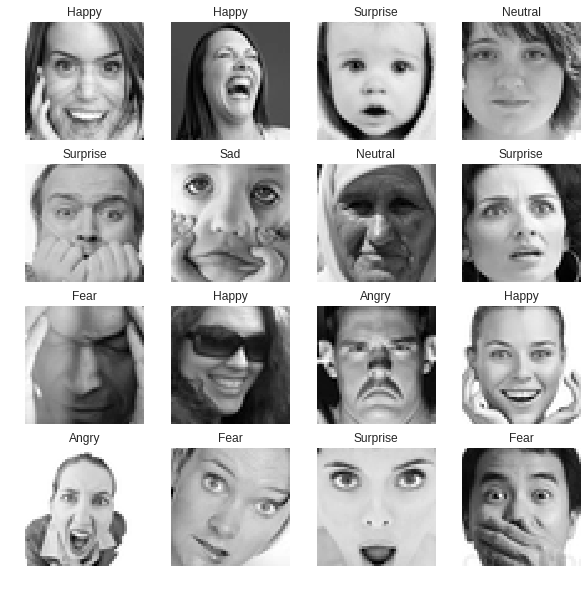

In [11]:
random_seed = 8
# randomly select 16 images
image_sample = data.sample(16, random_state=random_seed)

# Create subplots for images
_, axs = plt.subplots(4, 4, figsize=(10,10))
axs = axs.ravel()
i = 0
for _, row in image_sample.iterrows():
    one_image = np.array(row['pixels']).reshape(width,height)
    axs[i].imshow(one_image, cmap='gray')
    axs[i].set_title(emotion_map[row['emotion']])
    axs[i].axis('off')
    i += 1
    

In [10]:
# training data
data_train = data[data['Usage']=='Training']
# reshape image data (num of images, width, height, num of channels)
x_train = np.array(data_train['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.
# get labels
y_train = data_train['emotion'].as_matrix()

# validation data
data_val = data[data['Usage']!='Training']
# reshape image data (num of images, width, height, num of channels)
x_val = np.array(data_val['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.
# get labels
y_val = data_val['emotion'].as_matrix()


x_train.shape, y_train.shape, x_val.shape, y_val.shape

((28709, 48, 48, 1), (28709,), (7178, 48, 48, 1), (7178,))

In [0]:
# convert numpy arrays to tf tensors
training_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train[:,None])).batch(batch_size)
val_tf = tf.data.Dataset.from_tensor_slices((x_val, y_val[:,None])).batch(batch_size)

In [0]:
class EmotionCNN(tf.keras.Model):    
    # cnn initialization
    def __init__(self, num_labels, device='cpu:0', modelpath=None): 
        super(EmotionCNN, self).__init__()  
        self.device = device
        self.modelpath = modelpath
        self.l1 = tf.layers.Conv2D(16, 5, padding='same', 
                                   data_format='channels_last', activation=None)
        self.batch1 = tf.layers.BatchNormalization()
        self.l2 = tf.layers.Conv2D(16, 5, 2, padding='same', activation=None)
        self.batch2 = tf.layers.BatchNormalization()
        self.l3 = tf.layers.Conv2D(32, 5, padding='same', activation=None)
        self.batch3 = tf.layers.BatchNormalization()
        self.l4 = tf.layers.Conv2D(32, 5, 2, padding='same', activation=None)
        self.batch4 = tf.layers.BatchNormalization()
        self.l5 = tf.layers.Conv2D(64, 3, padding='same', activation=None)
        self.batch5 = tf.layers.BatchNormalization()
        self.l6 = tf.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        self.batch6 = tf.layers.BatchNormalization()
        self.l7 = tf.layers.Conv2D(64, 1, padding='same', activation=None)
        self.batch7 = tf.layers.BatchNormalization()
        self.l8 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.batch8 = tf.layers.BatchNormalization()
        self.l9 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch9 = tf.layers.BatchNormalization()
        self.l10 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.batch10 = tf.layers.BatchNormalization()
        self.l11 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch11 = tf.layers.BatchNormalization()
        self.l12 = tf.layers.Conv2D(num_labels, 3, 2, padding='same', 
                                    activation=None)        
       
    # label prediction based on input images
    def predict(self, input_data, training):        
        x = self.l1(input_data)
        x = self.batch1(x, training=training)
        x = self.l2(x)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=dropout_rate, training=training)
        x = self.l3(x)
        x = self.batch3(x, training=training)
        x = self.l4(x)
        x = self.batch4(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=dropout_rate, training=training)
        x = self.l5(x)
        x = self.batch5(x, training=training)
        x = self.l6(x)
        x = self.batch6(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=dropout_rate, training=training)
        x = self.l7(x)
        x = self.batch7(x, training=training)
        x = self.l8(x)
        x = self.batch8(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=dropout_rate, training=training)
        x = self.l9(x)
        x = self.batch9(x, training=training)
        x = self.l10(x)
        x = self.batch10(x, training=training)
        x = self.l11(x)
        x = self.batch11(x, training=training)
        x = self.l12(x)
        return tf.layers.flatten(x)
    
    def loss_func(self, input_data, labels, training):
        predictions = self.predict(input_data, training)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, 
                                                      logits=predictions)
        return loss
    
    def gradients(self, input_data, labels, training):
        with tfe.GradientTape() as tape:
            loss = self.loss_func(input_data, labels, training)
        return tape.gradient(loss, self.variables)                
        
    def fit(self, training_data, val_data, optimizer, num_epochs=100, verbose=10):             
        # track train and val losses and accuracies
        self.history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
        train_loss, train_acc = tfe.metrics.Mean('train_loss'), tfe.metrics.Accuracy('train_loss')
        val_loss, val_acc = tfe.metrics.Mean('val_loss'), tfe.metrics.Accuracy('val_loss') 
        
        # start training
        with tf.device(self.device):
            for i in range(num_epochs):
                # training with gradient descent
                for images, labels in tfe.Iterator(training_data):
                    grads = self.gradients(images, labels, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # compute loss on training data
                for images, labels in tfe.Iterator(training_data):                    
                    train_loss(self.loss_func(images, labels, False))
                    train_acc(tf.reshape(labels, [-1,]), 
                              tf.argmax(self.predict(images, training=False), axis=1))
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(train_acc.result().numpy())
                # reset loss and accuracy
                train_loss.init_variables()
                train_acc.init_variables()
                
                # compute loss on val data
                for images, labels in tfe.Iterator(val_data): 
                    val_loss(self.loss_func(images, labels, False))
                    val_acc(tf.reshape(labels, [-1,]), 
                            tf.argmax(self.predict(images, training=False), axis=1))
                self.history['val_loss'].append(val_loss.result().numpy())
                self.history['val_acc'].append(val_acc.result().numpy())
                # reset loss and accuracy
                val_loss.init_variables()
                val_acc.init_variables()                
                
                if (i % verbose == 0):
                    print("Train Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(i, self.history['train_loss'][-1], self.history['train_acc'][-1]))
                    print("Valid Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(i, self.history['val_loss'][-1], self.history['val_acc'][-1]))
                    print('----------------')

In [14]:
# use GPU if available
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'
print(device)
optimizer = tf.train.AdamOptimizer()
model = EmotionCNN(num_labels=7, device=device)

cpu:0


In [0]:
start_time = datetime.now()
# train 
model.fit(training_tf, val_tf, optimizer, num_epochs=num_epochs, verbose=10)
end_time = datetime.now()
print("----- Start time: {} End time: {} Runtime: {} ---".format(start_time, end_time, end_time-start_time))